In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Suppress oneDNN messages
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.get_logger().setLevel('ERROR')  # Only show errors

In [2]:
import pathlib, shutil, random
import keras
import tensorflow_hub as hub
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import text_dataset_from_directory
from keras import layers

In [4]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")
val_percentage = 0.2
batch_size = 32
max_tokens = 10_000
seq_length = 200

## Download and Prepare the Dataset

In [42]:
zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 83s 1us/step


In [44]:
for path in imdb_extract_dir.glob("*/*"):
        if path.is_dir():
            print(path)

/home/saeed/.keras/datasets/imdb/aclImdb/train/unsup
/home/saeed/.keras/datasets/imdb/aclImdb/train/neg
/home/saeed/.keras/datasets/imdb/aclImdb/train/pos
/home/saeed/.keras/datasets/imdb/aclImdb/test/neg
/home/saeed/.keras/datasets/imdb/aclImdb/test/pos


In [45]:
# Moves the test data unaltered
shutil.copytree(imdb_extract_dir / "test", test_dir)

# Splits the training data into a train set and a validation set
val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

## Create Train/Val/Test Sets

In [6]:
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


## Prepare Vectorized Datasets

> Dataset < 20k samples → TF-IDF + MLP
> 
> Dataset > 50k samples → int + Embeddings

### Method 1: Text → TF-IDF → MLP

In [10]:
text_vectorization_tfidf = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="tf-idf",
    pad_to_max_tokens=True,
    ngrams=2
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization_tfidf.adapt(train_ds_no_labels)

train_ds_tfidf = train_ds.map(
    lambda x, y: (text_vectorization_tfidf(x), y), num_parallel_calls=8
)
val_ds_tfidf = val_ds.map(
    lambda x, y: (text_vectorization_tfidf(x), y), num_parallel_calls=8
)
test_ds_tfidf = test_ds.map(
    lambda x, y: (text_vectorization_tfidf(x), y), num_parallel_calls=8
)

In [13]:
for texts, labels in train_ds_tfidf:
    print(texts.shape)
    print(labels.shape)
    print(texts[0])
    break

(32, 10000)
(32,)
tf.Tensor(
[312.43396     6.9747505   3.5574439 ...   0.          0.
   0.       ], shape=(10000,), dtype=float32)


### Method 2: Text → int → Embedding → CNN/LSTM/Transformer

In [14]:
text_vectorization_int = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length, 
    pad_to_max_tokens=True,
    ngrams=2
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization_int.adapt(train_ds_no_labels)

train_ds_int = train_ds.map(
    lambda x, y: (text_vectorization_int(x), y), num_parallel_calls=8
)
val_ds_int = val_ds.map(
    lambda x, y: (text_vectorization_int(x), y), num_parallel_calls=8
)
test_ds_int = test_ds.map(
    lambda x, y: (text_vectorization_int(x), y), num_parallel_calls=8
)

In [18]:
for texts, labels in train_ds_int:
    print(texts.shape)
    print(labels.shape)
    print(texts[0])
    break

(32, 200)
(32,)
tf.Tensor(
[ 337    1   11   18   38    2 1130 7469    4  515    5 4703  935    1
    6 3549   74   11   22   44    4  212  736  120    1  365   10  572
  233    6  432    1   43   11 3656    8   11   30    1 8810  387 1003
 7186    1    1    4    1  746 1325   87 6167    4 1288  115  129    1
   38    1    6 3552  138   26 1795    1    1    1    1    1  878    6
   28  202 2013   29  737    6    1   30    5   26  497    4 1417 2666
 1322    1   48    5    1 1436  344    1    1    1  307  221    4    1
    5 2261    1    1   17    2 1471    5  104    3    1   22    2    1
  240    1   23   68  633    2  140  165   33 1417    3    1 3415   29
 1099   16   36 5213  426  120   29    3 3068 3698    1  875    1  172
   48   22    2  789    3  125    1    1    1    1    1   22 1415    1
  426    7 9902   30    5    2 8557    1    1    1    1 1241  237    6
   27    4 9184   16   30    5    2    1 6358    1    1    1  806  969
  271   50    3  161   12   11   14    4 1009 2564

## MLP Model

In [26]:
inp = layers.Input(shape=(max_tokens,))
x = layers.Dense(8, activation='relu')(inp)
x = layers.Dropout(0.3)(x)
x = layers.Dense(8, activation='relu')(inp)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model_mlp_bigram = keras.Model(inp, out)
model_mlp_bigram.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │        80,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,017 (312.57 KB)

 Trainable params: 80,017 (312.57 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_mlp_bigram.compile(optimizer="adam", loss="binary_crossentropy",
                         metrics=["accuracy"])

In [28]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=3,
)
history_1 = model_mlp_bigram.fit(
    train_ds_tfidf,
    validation_data=val_ds_tfidf,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7150 - loss: 0.5494 - val_accuracy: 0.8794 - val_loss: 0.3444
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.7849 - loss: 0.3746 - val_accuracy: 0.8652 - val_loss: 0.3336
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8081 - loss: 0.3299 - val_accuracy: 0.8708 - val_loss: 0.3012
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8347 - loss: 0.2919 - val_accuracy: 0.8794 - val_loss: 0.3044
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8676 - loss: 0.2645 - val_accuracy: 0.8834 - val_loss: 0.3084
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.8837 - loss: 0.2384 - val_accuracy: 0.8822 - val_loss: 0.3231


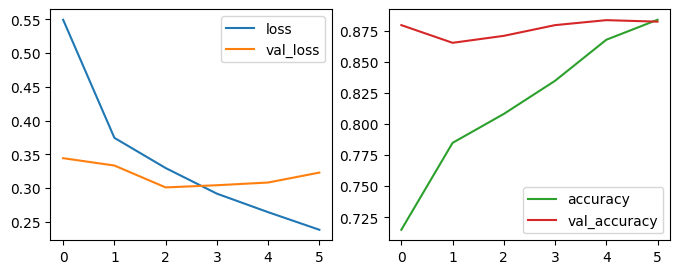

In [29]:
history_df = pd.DataFrame(history_1.history)
history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [31]:
loss, acc = model_mlp_bigram.evaluate(test_ds_tfidf)
print(f"Test Accuracy: {acc*100:.2f}%")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8694 - loss: 0.3046
Test Accuracy: 86.94%


## MLP + Pre-trained Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip -qq glove.6B.zip

In [32]:
# choose embedding size
embedding_dim = 50
glove_path = f"glove.6B.{embedding_dim}d.txt"

embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

In [34]:
vocabulary = text_vectorization_int.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i >= max_tokens:
        continue
    vec = embeddings_index.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

In [35]:
embedding_layer_glove = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False,
)

In [44]:
inp = layers.Input(shape=(seq_length,))
x = embedding_layer_glove(inp)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model_mlp_embed = keras.Model(inp, out)
model_mlp_embed.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,105 (1.91 MB)

 Trainable params: 1,105 (4.32 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [45]:
model_mlp_embed.compile(optimizer="adam", loss="binary_crossentropy",
                        metrics=["accuracy"])

In [46]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=3,
)
history_2 = model_mlp_embed.fit(
    train_ds_int,
    validation_data=val_ds_int,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5821 - loss: 0.6736 - val_accuracy: 0.6960 - val_loss: 0.6237
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6746 - loss: 0.6141 - val_accuracy: 0.7354 - val_loss: 0.5612
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7075 - loss: 0.5781 - val_accuracy: 0.7458 - val_loss: 0.5430
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7225 - loss: 0.5648 - val_accuracy: 0.7462 - val_loss: 0.5319
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7226 - loss: 0.5601 - val_accuracy: 0.7450 - val_loss: 0.5298
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7303 - loss: 0.5547 - val_accuracy: 0.7408 - val_loss: 0.5376
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7298 - loss: 0.5510 - val_accuracy: 0.7496 - val_loss: 0.5212
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7334 - loss: 0.5472 - val_accuracy:

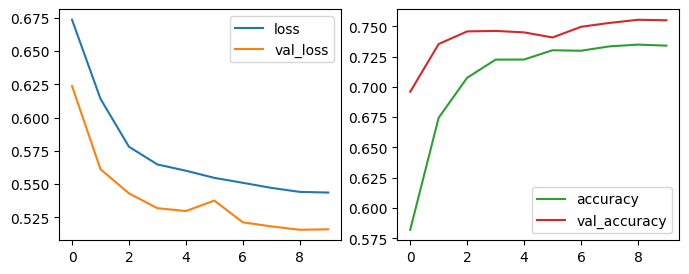

In [48]:
history_df = pd.DataFrame(history_2.history)
history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [49]:
loss, acc = model_mlp_embed.evaluate(test_ds_int)
print(f"Test Accuracy: {acc*100:.2f}%")

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7346 - loss: 0.5331
Test Accuracy: 73.46%


In [50]:
inp = layers.Input(shape=(seq_length,))
x = embedding_layer_glove(inp)
x = layers.Bidirectional(layers.LSTM(16))(x)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(1, activation='sigmoid')(x)

model_rnn_embed = keras.Model(inp, out)
model_rnn_embed.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32)             │         8,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 508,849 (1.94 MB)

 Trainable params: 8,849 (34.57 KB)

 Non-trainable params: 500,000 (1.91 MB)

In [51]:
model_rnn_embed.compile(optimizer="adam", loss="binary_crossentropy",
                        metrics=["accuracy"])

In [52]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=3,
)
history_3 = model_rnn_embed.fit(
    train_ds_int,
    validation_data=val_ds_int,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.5817 - loss: 0.6723 - val_accuracy: 0.6726 - val_loss: 0.6072
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7161 - loss: 0.5755 - val_accuracy: 0.7740 - val_loss: 0.5010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.7703 - loss: 0.5111 - val_accuracy: 0.7902 - val_loss: 0.4701
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7823 - loss: 0.4893 - val_accuracy: 0.7826 - val_loss: 0.4563
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7943 - loss: 0.4620 - val_accuracy: 0.7860 - val_loss: 0.4574
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.8033 - loss: 0.4472 - val_accuracy: 0.8062 - val_loss: 0.4222
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.8100 - loss: 0.4363 - val_accuracy: 0.8000 - val_loss: 0.4278
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.8192 - loss: 0.4205 - 

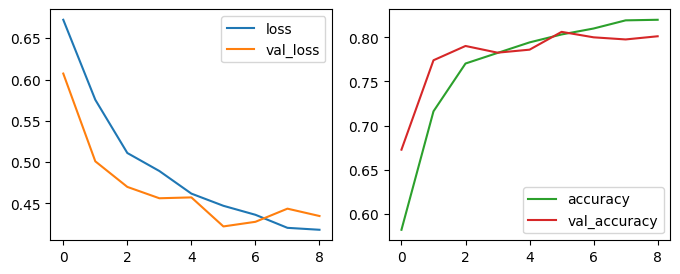

In [53]:
history_df = pd.DataFrame(history_3.history)
history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [55]:
loss, acc = model_rnn_embed.evaluate(test_ds_int)
print(f"Test Accuracy: {acc*100:.2f}%")

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8032 - loss: 0.4253
Test Accuracy: 80.32%


In [32]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/gnews-swivel/tensorFlow2/tf2-preview-20dim-with-oov")

print("Path to model files:", path)
# will be like ~/.cache/kagglehub/models/google/gnews-swivel/tensorFlow2/tf2-preview-20dim-with-oov/1
# you can extract the contents of the downloaded gnews-swivel-tensorflow2-tf2-preview-20dim-with-oov-v1.tar.gz here

Path to model files: /home/saeed/.cache/kagglehub/models/google/gnews-swivel/tensorFlow2/tf2-preview-20dim-with-oov/1


https://www.kaggle.com/models/google/gnews-swivel/

In [33]:
embed = hub.load("https://www.kaggle.com/models/google/gnews-swivel/TensorFlow2/tf2-preview-20dim-with-oov/1")
embeddings = embed(["cat is on the mat", "dog is in the fog"])

In [39]:
embeddings[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.86663955,  0.3591772 ,  0.00579672,  0.681002  , -0.54226625,
        0.22343187, -0.38796628,  0.62195706,  0.22117122, -0.48538068,
       -1.2674141 ,  0.88636893, -0.3284907 , -0.13924702, -0.53327686,
        0.5739708 , -0.05905761,  0.13629246, -1.1718255 , -0.3149434 ],
      dtype=float32)>

## Transformer-based Method
- Order & Contextual awareness
- No need for vectorization and embedding layer

In [ ]:
import keras_hub

In [ ]:
preprocessor = keras_hub.models.BertPreprocessor.from_preset(
    "bert_tiny_en_uncased"
)

encoder = keras_hub.models.BertBackbone.from_preset(
    "bert_tiny_en_uncased"
)

In [ ]:
text_input = layers.Input(shape=(), dtype="string")

x = preprocessor(text_input)
x = encoder(x)

# pooled_output = sentence embedding
x = x["pooled_output"]

x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model_bert = keras.Model(text_input, output)
model_bert.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
hisory_4 = model_bert.fit(train_ds, validation_data=val_ds, epochs=5)